# Subwavelength polarizing diffraction gratings experimental topography

In this notebook I am going to test the polarization obtained from an experimental profile of LIPSS

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import scipy as sp
import copy
import matplotlib.pyplot as plt
import hickle as hkl
from pprint import  pprint
import matplotlib.mlab as mlab
from scipy.stats import norm

np.set_printoptions(precision=3)

In [9]:
from py_lipss.old.pyS4 import simS4, nanoxz
from py_lipss.old.utils import plotters, numpyhacks
from py_lipss.old.utils import materials as pymaterials

from py_lipss.old.polarization_parameters import polarization_reflection_experiment
from py_lipss.old.computation import compute_3_structures
from py_lipss.old.utils_drawing import plot_Jones_ellipses_in_out

## Sample PL14_30 loading 8 Units cell

In [10]:
# Defining parameters
um = 1.
mm = 1e3
nm = 1e-3
meter = 1e6
N_LATTICES = 8
a_0 = 0.580 * um #[\mu m] lattice parameter in microns 
a = a_0 *  N_LATTICES
#H = 0.3427 * mu  #[\mu m] Thickness of the grating
#w = 5. #[\mu m] width of the prism
wavelength = 0.85 * um  #[\mu m] incident wavelength

G = 31 # Truncation in k-space
NP = 100  # resolution of the fields
NL =  51 # Even number for perfect alignment
NP_HIST = 10000
#H = 0.21 * um
#Hi = H/NL

options = {"PolarizationDecomposition": False, "Verbosity": 0}

In [18]:
eV_work = pymaterials.eV2nm / wavelength * nm
epssteel = pymaterials.load_material('steel',eV_work, folder='../../../exp_data/', verbose=True)
materials = {"Vacuum": 1.0, "Steel": epssteel}

['steel_fagor_nk.dat']


In [19]:
epssteel

(-7.4718499584161275+21.33611817699896j)

In [21]:
eV_work

1.4586376164283197

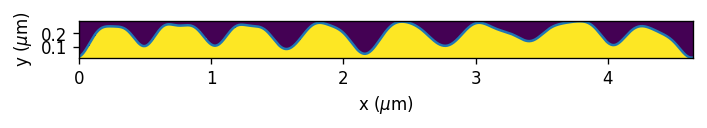

In [22]:
x0, y0 = np.loadtxt('../../../exp_data/DATA_PL14_30_Data_8periods.dat', unpack=True)
x0, y0 =  x0 * meter, y0 * meter
x0 = x0/x0.max() * a

#x0 = np.linspace(0, a, 1e5)
#z0 = np.sin(2*x0*np.pi/ a_0 - np.pi/2.) # + np.random.random(50)
#z0 = x0 **2

inner = numpyhacks.LUT_xzfun(x0, y0, NL)
mater_lut_inner = {"Vacuum":0, "Steel":1}
layers_pat = range(1,NL+1)

plt.figure(dpi=120)
plt.imshow(inner, extent=[x0.min(),x0.max(),y0.min(),y0.max()])
plt.plot(x0,y0)
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
plt.tight_layout()

In [23]:
H = y0.max()
Hi = H/NL
layers =  [{"Name":"l0", "Thickness":0, "Material":"Vacuum"}]
for iii in range(1,NL+1):
    layers.append({"Name":"l{}".format(iii), "Thickness":Hi, "Material":"Vacuum"})
    
layers.append({"Name":"l{}".format(iii+1), "Thickness":0., "Material":"Steel"})


In [24]:
# Define the structure using py_lipss
grating = nanoxz.NanoArray2D(a, G=G, options=options)
grating.set_materials(materials=materials)
grating.set_layers(layers)

grating.add_pattern(inner, range(1,NL+1), mater_lut_inner)
grating.set_excite(wavelength)
#orders_list = grating.orders_list

talbot_length = a**2 / wavelength
#z = np.linspace(-0.1*(talbot_length), 0.1*(talbot_length)+ H, NP)
z = np.linspace(-2., H + 2., NP)
x = np.linspace(-a / 2, a / 2., NP)

grating.get_fluxes()
#grating.get_amps()
grating.get_fields(x=x, y=[0], z=z)
grating.get_epsilon(x=x, y=[0], z=z)
grating.a = grating._a
grating.z = z

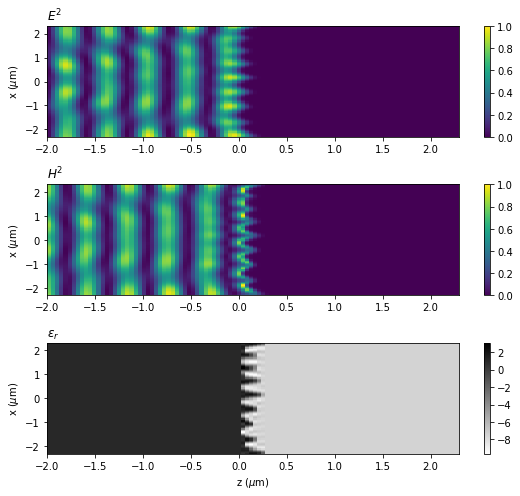

In [25]:
fg = plotters.plot2D_E2H2Eps(grating)

In [26]:
#TEMPORAL FIX
grating.sim_info.add('patterns')

In [27]:
# Setting the nanostructure to test
z=sp.linspace(-100 * wavelength,-200 *wavelength, NP_HIST)
grating.sim_info
grt = copy.copy(grating)
grt.stop(clear_results=True)
grt.source['pAmplitude'] = 1. / np.sqrt(2)
grt.source['sAmplitude'] = 1. / np.sqrt(2.)
grt.get_fields(0, 0, z=z)
grt.get_fluxes()
grt.start(run_calcs=True)

In [28]:
grt, grt0, grt00 = compute_3_structures(grt)

In [29]:
grt.fluxes.sum(axis=1)[0,1]

(-0.2796866423823536+0j)

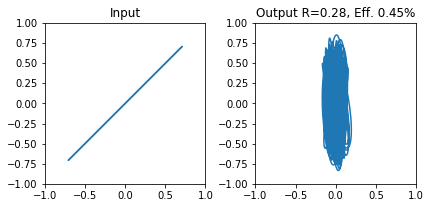

In [30]:
fg = plot_Jones_ellipses_in_out(grt, grt00, grt0,)

fg = plotters.plot_Jones_ellipses_in_out_projection(
    grt, grt00, grt0, alpha_top=0.01, alpha_min=0.01, marker='.')

z=sp.linspace(-100 * l,-200 *l, NP_HIST)
fg = plotters.plot_input_output_3d(grt, grt00, grt0,z,      
                                   alpha=0.4, 
                                   figargs=dict(figsize=(5,3), dpi=72),
                                  color='red')
fg.savefig('3D_polz_exp.svg')

In [25]:
stok, R, eta = polarization_reflection_experiment(
    grt, z=sp.linspace(-100 * wavelength, -201 * wavelength, NP_HIST))

(10000,)
-0.93144419794 0.0668284709877
(10000,)
-0.066778682532 0.240196626628
(10000,)
0.0972648594717 0.237342362038


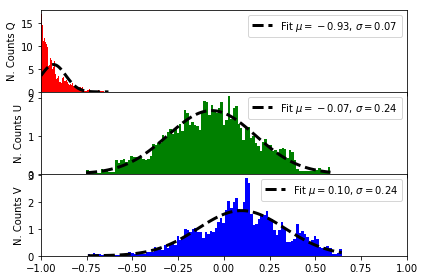

In [27]:
fg, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
facecolors = ['red', 'green', 'blue']
stokes_names = ['Q', 'U', 'V']
for _ in range(stok.shape[1] - 1):
    stk = stok[:, _ + 1]
    print stk.shape
    (mu, sigma) = norm.fit(stk)
    weights = sp.ones_like(stk) / float(len(stk))
    n, bins, patches = axes[_].hist(
        stk, 100, normed=1, facecolor=facecolors[_], histtype='stepfilled')
    y = mlab.normpdf(bins, mu, sigma)
    print mu, sigma
    axes[_].plot(
        bins,
        y,
        'k--',
        linewidth=3,
        label='Fit $\mu={:.2f}$, $\sigma={:.2f}$'.format(mu, sigma),
    )
    axes[_].set_ylabel("N. Counts {}".format(stokes_names[_]))
    axes[_].set_xlim(-1., 1)
    axes[_].legend(loc=0)
    #axes[_].s

fg.tight_layout()
fg.subplots_adjust(hspace=0)
fg.savefig('histograms_exp_pols.svg')

# Conclusions and further research

As we can see from the figures the modification of the polarization for the perfect cell is only that the diffracted order 
and a bit of displacement, however the supercell with defects could present some problems in the polarization for defects near equal to 
sin function.
We have used the histogram of the Stokes Parameter along a z-direction. Further testing is needed